In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# ! pip install sdv

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import numpy as np

import commonfunc

In [5]:
data_set_path = "./sampled_data_csv_100/"

# procedureevents_mv

## Data Process

In [7]:
procedureevents_mv_df = commonfunc.read_csv_no_rowid(data_set_path + "procedureevents_mv.csv")

In [8]:
procedureevents_mv_df.head()

,subject_id,hadm_id,icustay_id,starttime,endtime,itemid,value,valueuom,location,locationcategory,...,ordercategoryname,secondaryordercategoryname,ordercategorydescription,isopenbag,continueinnextdept,cancelreason,statusdescription,comments_editedby,comments_canceledby,comments_date
0,87197,176931,209341.0,2109-11-16 09:00:00,2109-11-16 21:17:00,224277,737.0,min,LL Post Forearm,Peripheral - old,...,Peripheral Lines,NaN,Task,1,0,0,FinishedRunning,NaN,NaN,NaN
1,87197,176931,209341.0,2109-11-16 09:16:00,2109-11-17 16:00:00,224277,1844.0,min,R Hand,Peripheral - old,...,Peripheral Lines,NaN,Task,1,0,0,FinishedRunning,NaN,NaN,NaN
2,87197,176931,209341.0,2109-11-16 20:00:00,2109-11-16 20:28:00,224277,28.0,min,RU Ant Forearm,Peripheral - old,...,Peripheral Lines,NaN,Task,1,0,0,FinishedRunning,NaN,NaN,NaN
3,87197,176931,209341.0,2109-11-16 22:30:00,2109-11-16 22:31:00,225401,1.0,None,NaN,NaN,...,Procedures,NaN,Electrolytes,0,0,0,FinishedRunning,NaN,NaN,NaN
4,87197,176931,209341.0,2109-11-16 22:30:00,2109-11-16 22:31:00,225454,1.0,None,NaN,NaN,...,Procedures,NaN,Electrolytes,0,0,0,FinishedRunning,NaN,NaN,NaN


## Data Process

In [9]:
# Drop some null value
# procedureevents_mv_df.dropna(subset=['hadm_id', ], inplace=True, axis=0)

### Data preproces

In [10]:
# Drop some columns
procedureevents_mv_df.drop(['location', 'locationcategory', 'storetime', 'cgid', 'secondaryordercategoryname', 
    'continueinnextdept', 'cancelreason', 'comments_editedby', 'comments_canceledby', 'comments_date'], axis=1, inplace=True)

#### Deal with missing values

In [12]:
commonfunc.nan_count(procedureevents_mv_df)

Total columns: 14
Total rows: 591
--------------
subject_id                  0
hadm_id                     0
icustay_id                  2
starttime                   0
endtime                     0
itemid                      0
value                       0
valueuom                    0
orderid                     0
linkorderid                 0
ordercategoryname           0
ordercategorydescription    0
isopenbag                   0
statusdescription           0
dtype: int64


#### Set the column types

In [13]:
procedureevents_mv_df.dtypes

subject_id                    int64
hadm_id                       int64
icustay_id                  float64
starttime                    object
endtime                      object
itemid                        int64
value                       float64
valueuom                     object
orderid                       int64
linkorderid                   int64
ordercategoryname            object
ordercategorydescription     object
isopenbag                     int64
statusdescription            object
dtype: object

In [14]:
procedureevents_mv_df['starttime'] = pd.to_datetime(procedureevents_mv_df['starttime'])
procedureevents_mv_df['endtime'] = pd.to_datetime(procedureevents_mv_df['endtime'])

In [15]:
procedureevents_mv_df.dtypes

subject_id                           int64
hadm_id                              int64
icustay_id                         float64
starttime                   datetime64[ns]
endtime                     datetime64[ns]
itemid                               int64
value                              float64
valueuom                            object
orderid                              int64
linkorderid                          int64
ordercategoryname                   object
ordercategorydescription            object
isopenbag                            int64
statusdescription                   object
dtype: object

#### Process special data

In [16]:
invalid_index = procedureevents_mv_df.loc[(procedureevents_mv_df['starttime'] > procedureevents_mv_df['endtime']) == True].index
procedureevents_mv_df.drop(invalid_index, inplace=True, axis=0)

#### Process some special value

In [18]:
icustays_df = commonfunc.read_csv_no_rowid(data_set_path+"icustays.csv")

In [19]:
icu_intime_df = icustays_df.loc[:, ['icustay_id', 'intime']]
icu_intime_df['intime'] = pd.to_datetime(icu_intime_df['intime'])

In [20]:
procedureevents_mv_mid_df = pd.merge(left=procedureevents_mv_df, right=icu_intime_df, how='left', on=['icustay_id'])

In [21]:
procedureevents_mv_mid_df.dtypes

subject_id                           int64
hadm_id                              int64
icustay_id                         float64
starttime                   datetime64[ns]
endtime                     datetime64[ns]
itemid                               int64
value                              float64
valueuom                            object
orderid                              int64
linkorderid                          int64
ordercategoryname                   object
ordercategorydescription            object
isopenbag                            int64
statusdescription                   object
intime                      datetime64[ns]
dtype: object

In [24]:
procedureevents_mv_mid_df['endtime'] = procedureevents_mv_mid_df.apply(commonfunc.time_process, args=('starttime', 'endtime'), axis=1)
procedureevents_mv_mid_df['starttime'] = procedureevents_mv_mid_df.apply(commonfunc.time_process, args=('intime', 'starttime'), axis=1)

procedureevents_mv_mid_df['endtime'] = procedureevents_mv_mid_df['endtime'].astype(np.int64)
procedureevents_mv_mid_df = procedureevents_mv_mid_df.dropna(subset=['starttime'])
procedureevents_mv_mid_df['starttime'] = procedureevents_mv_mid_df['starttime'].astype(np.int64)

AttributeError: 'float' object has no attribute 'total_seconds'

In [25]:
procedureevents_mv_mid_df.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'starttime', 'endtime', 'itemid',
       'value', 'valueuom', 'orderid', 'linkorderid', 'ordercategoryname',
       'ordercategorydescription', 'isopenbag', 'statusdescription', 'intime'],
      dtype='object')

In [26]:
procedureevents_mv_df = procedureevents_mv_mid_df.drop(['subject_id', 'hadm_id', 'icustay_id', 'intime'], axis=1)

---

## Build model

### Set constraints

In [27]:
procedureevents_mv_df.columns

Index(['starttime', 'endtime', 'itemid', 'value', 'valueuom', 'orderid',
       'linkorderid', 'ordercategoryname', 'ordercategorydescription',
       'isopenbag', 'statusdescription'],
      dtype='object')

In [28]:
from sdv.constraints import FixedCombinations

fixed_itemid_value_valueuom_constraint = FixedCombinations(
    column_names=['itemid', 'value', 'valueuom']
)

fixed_itemid_orderid_linkorderid_constraint = FixedCombinations(
    column_names=['orderid', 'linkorderid', 'ordercategoryname', 'ordercategorydescription']
)

In [29]:
constraints = [fixed_itemid_value_valueuom_constraint, fixed_itemid_orderid_linkorderid_constraint]

### Build model

In [30]:
train_data = procedureevents_mv_df

In [32]:
best_model = commonfunc.build_model(constraints=constraints, train_data=train_data)

Strat training ...
Tabular Preset


Sampling rows: 100%|██████████| 591/591 [00:00<00:00, 7894.15it/s]


Gaussian Copula


Sampling rows: 100%|██████████| 591/591 [00:00<00:00, 8564.18it/s]


CTGAN


Sampling rows: 100%|██████████| 591/591 [00:00<00:00, 3180.24it/s]


CopulaGAN


Sampling rows: 100%|██████████| 591/591 [00:00<00:00, 4252.91it/s]


TVAE


Sampling rows: 100%|██████████| 591/591 [00:00<00:00, 6828.82it/s]


Training finished!
Strat evaluating ...
Evaluating finished!
Gaussian Copula


Sampling rows: 100%|██████████| 591/591 [00:00<00:00, 7035.33it/s]


The best model is: copulagan
The ContinuousKL_score is: 0.6896083129244293
The DiscreteKL_score is: 0.6344406795945677
The total score is: 0.5437832415168903


In [34]:
model_save_path ="C:\\Users\\shrus\\Documents\\Synthetic-data-generation\\models_100\\"+ "procedureevents_mv_model.pkl"
commonfunc.save_model(best_model, model_save_path)

---

## Evaluate data

### Generate synthetic data

In [36]:
date_load_path = "C:\\Users\\shrus\\Documents\\Synthetic-data-generation\\models_100\\" + "procedureevents_mv_model.pkl"
model = commonfunc.load_model(date_load_path)

In [37]:
sample = model.sample(num_rows=len(train_data))

Sampling rows: 100%|██████████| 591/591 [00:00<00:00, 8409.64it/s]


### Evaluation

In [38]:
from sdv.evaluation import evaluate

In [39]:
evaluate(sample, train_data, metrics=['ContinuousKLDivergence'])

0.6698027997118824

In [40]:
evaluate(sample, train_data, metrics=['DiscreteKLDivergence'])

0.6471764276537905

In [41]:
evaluate(sample, train_data)

0.5461408112196227

<Axes: >

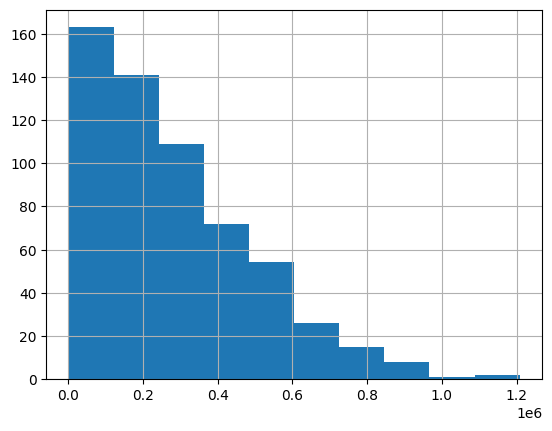

In [42]:
sample['starttime'].hist()

<Axes: >

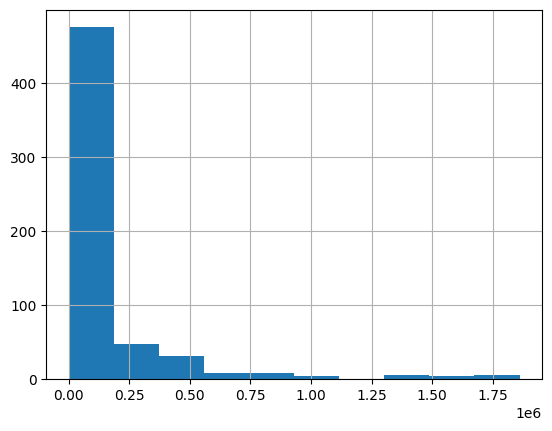

In [43]:
train_data['starttime'].hist()

array([[<Axes: title={'center': 'starttime'}>,
        <Axes: title={'center': 'endtime'}>,
        <Axes: title={'center': 'itemid'}>],
       [<Axes: title={'center': 'value'}>,
        <Axes: title={'center': 'orderid'}>,
        <Axes: title={'center': 'linkorderid'}>],
       [<Axes: title={'center': 'isopenbag'}>, <Axes: >, <Axes: >]],
      dtype=object)

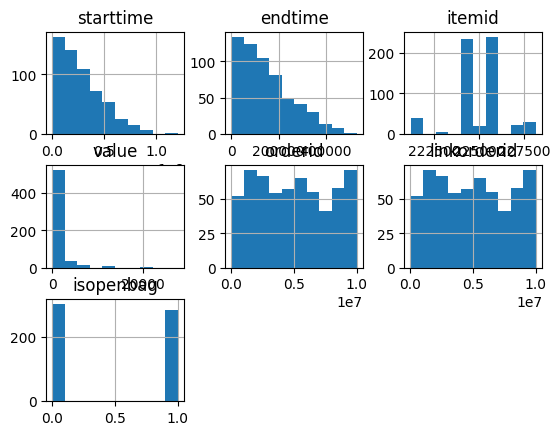

In [44]:
sample.hist()

array([[<Axes: title={'center': 'starttime'}>,
        <Axes: title={'center': 'endtime'}>,
        <Axes: title={'center': 'itemid'}>],
       [<Axes: title={'center': 'value'}>,
        <Axes: title={'center': 'orderid'}>,
        <Axes: title={'center': 'linkorderid'}>],
       [<Axes: title={'center': 'isopenbag'}>, <Axes: >, <Axes: >]],
      dtype=object)

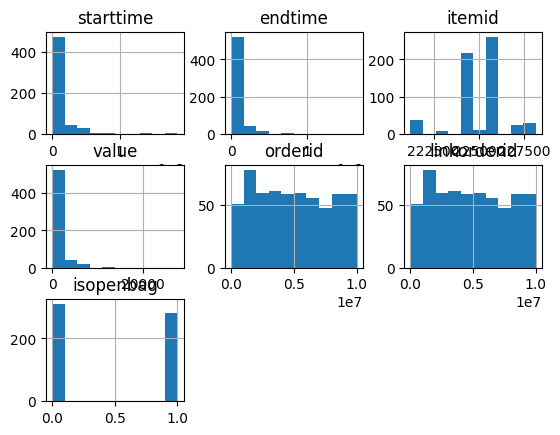

In [45]:
train_data.hist()

<Axes: >

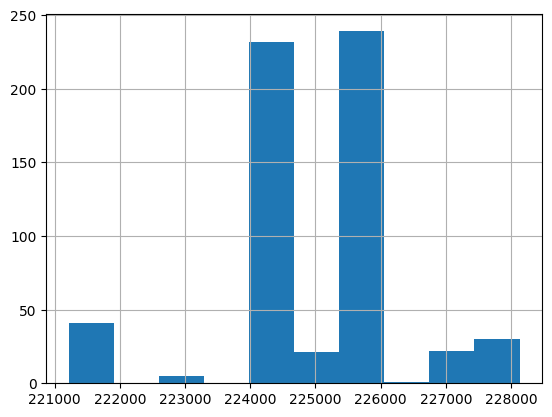

In [46]:
sample.sort_values('itemid')['itemid'].hist()

<Axes: >

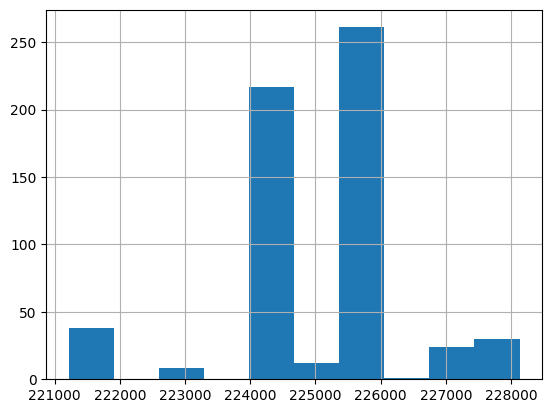

In [47]:
train_data.sort_values('itemid')['itemid'].hist()